In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

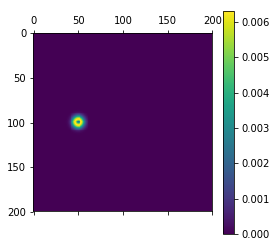

In [35]:
def next_step_probability(current_i, current_j, sigma_large, sigma_small, size):
    grid_ii, grid_jj = np.mgrid[0:size, 0:size]
    rad = (
        (((grid_ii - current_i) ** 2) / (sigma_large ** 2))
        + (((grid_jj - current_j) ** 2)/ (sigma_large ** 2))
    )
    large = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_large * sigma_large)
    rad = (
        (((grid_ii - current_i) ** 2) / (sigma_small ** 2))
        + (((grid_jj - current_j) ** 2)/ (sigma_small ** 2))
    )
    small = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_small * sigma_small)
    p_next_step = large - 0.2 * small
    return p_next_step / p_next_step.sum()

p = next_step_probability(100, 50, 4, 2, 200)
plt.matshow(p)
plt.colorbar()

In [32]:
# ... let's say we want to have a long-tailed next step probability

# The Walker class has less parameters!
# its responsibilities are clearer

# smells that remain
# need to do the bookkeeping for i, j in case you want to create / simulate entire trajectories


def flat_activation_map_initializer(size):
    return np.ones((size, size))


def hills_activation_map_initializer(size):
    grid_ii, grid_jj = np.mgrid[0:size, 0:size]
    i_waves = np.sin(grid_ii/130) + np.sin(grid_ii/10)
    i_waves /= i_waves.max()
    j_waves = np.sin(grid_jj/100) + np.sin(grid_jj/50)+ np.sin(grid_jj/10)
    j_waves /= j_waves.max()
    activation_map = j_waves + i_waves
    return activation_map


def labyrinth_activation_map_initializer(size):
    activation_map = np.ones((size, size))
    activation_map[50:100, 50:60] = 0
    activation_map[20:89, 80:90] = 0
    activation_map[90:120, 0:10] = 0
    activation_map[120:size, 30:40] = 0
    activation_map[180:190, 50:60] = 0

    activation_map[50:60, 50:200] = 0
    activation_map[179:189, 80:130] = 0
    activation_map[110:120, 0:190] = 0
    activation_map[120:size, 30:40] = 0
    activation_map[180:190, 50:60] = 0

    return activation_map


class GaussianNextStepBuilder:
    def __init__(self, size, sigma_i, sigma_j):
        self.sigma_i = sigma_i
        self.sigma_j = sigma_j
        self.size = size
        self._grid_ii, self._grid_jj = np.mgrid[0:size, 0:size]

    def next_step_probability(self, current_i, current_j):
        grid_ii, grid_jj = self._grid_ii, self._grid_jj
        sigma_i, sigma_j = self.sigma_i, self.sigma_j

        rad = (
            (((grid_ii - current_i) ** 2) / (sigma_i ** 2))
            + (((grid_jj - current_j) ** 2)/ (sigma_j ** 2))
        )

        p_next_step = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_i * sigma_j)
        return p_next_step / p_next_step.sum()


class RingNextStepBuilder:
    def __init__(self, size, sigma_large, sigma_small):
        self.sigma_large = sigma_large
        self.sigma_small = sigma_small
        self.size = size
        self._grid_ii, self._grid_jj = np.mgrid[0:size, 0:size]

    def next_step_probability(self, current_i, current_j):
        grid_ii, grid_jj = self._grid_ii, self._grid_jj
        sigma_large, sigma_small = self.sigma_large, self.sigma_small
        rad = (
            (((grid_ii - current_i) ** 2) / (sigma_large ** 2))
            + (((grid_jj - current_j) ** 2)/ (sigma_large ** 2))
        )
        large = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_large * sigma_large)
        rad = (
            (((grid_ii - current_i) ** 2) / (sigma_small ** 2))
            + (((grid_jj - current_j) ** 2)/ (sigma_small ** 2))
        )
        small = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_small * sigma_small)
        p_next_step = large - 0.2 * small
        return p_next_step / p_next_step.sum()


class Walker:

    def __init__(self, size, activation_map, probability_map_builder):
        self.size = size
        self.activation_map = activation_map
        self.probability_map_builder = probability_map_builder

    @classmethod
    def from_activation_map_initializer(cls, size, initializer, probability_map_builder):
        activation_map = initializer(size)
        activation_map /= activation_map.sum()
        return cls(size, activation_map, probability_map_builder)

    def _compute_selection_map(self, next_step_map):
        selection_map = next_step_map * self.activation_map
        selection_map /= selection_map.sum()
        return selection_map

    def sample_next_step(self, current_i, current_j, random_state=np.random):
        next_step_map = self.probability_map_builder.next_step_probability(current_i, current_j)
        selection_map = self._compute_selection_map(next_step_map)

        r = random_state.rand()
        cumulative_map = np.cumsum(selection_map)
        cumulative_map = cumulative_map.reshape(selection_map.shape)
        i_next, j_next = np.argwhere(cumulative_map >= r)[0]

        return i_next, j_next

    def evaluate_position(self, current_i, current_j):
        next_step_map = self.probability_map_builder.next_step_probability(current_i, current_j)
        selection_map = self._compute_selection_map(next_step_map)
        return selection_map[current_i, current_j]


def plot_trajectory(trajectory, activation_map):
    trajectory = np.asarray(trajectory)
    plt.matshow(activation_map)
    plt.plot(trajectory[:, 1], trajectory[:, 0])
    plt.show()


In [38]:
next_step_builder = RingNextStepBuilder(size=200, sigma_large=4, sigma_small=2)
walker = Walker.from_activation_map_initializer(
    size=200,
    initializer=labyrinth_activation_map_initializer,
    probability_map_builder=next_step_builder,
)

i, j = 100, 50
trajectory = []
for _ in range(1000):
    i, j = walker.sample_next_step(i, j)
    trajectory.append((i, j))

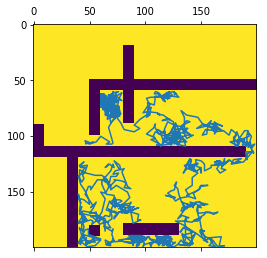

In [39]:
plot_trajectory(trajectory, walker.activation_map)
